In [2]:
from google.cloud import bigquery
import pandas as pd 
import chime   
import seaborn as sns
client = bigquery.Client("gcp-wow-rwds-ai-checkout-dev")

/opt/homebrew/lib/python3.11/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [30]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

## Bakery - Stores Matching on Historical Performance

In [207]:
check = client.query(
"""
 --"278258 Woolworths Smash Cake, 104629 Woolworths Vanilla Cake with Lotus Biscoff, 104984 Woolworths Assorted Celebration Cake, 118177 Raspberry and White Choc Loaded Muffins 4 Pack"
 with 
weekly_site_level_all_skus_combined AS (
    SELECT 
        DATE_TRUNC(TXNStartDate, WEEK) AS txn_week,
        Site,
        COUNT(DISTINCT BasketKey) AS n_transactions, 
        SUM(TotalAmountIncldTax) AS total_sales_amount
    FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass
    LEFT JOIN `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_masterdata_view.dim_article_master_v` am
        ON ass.Article = am.Article 
    WHERE ass.SalesOrg = 1005
    AND am.SalesOrg = 1005
    AND LOWER(ass.SalesChannelDescription) <> "online"
    AND ass.TXNStartDate >= DATE_ADD(DATE("2024-08-12"), INTERVAL -13 WEEK) 
    --AND ass.Article IN ("278258", "104629", "104984", "118177")
    AND ass.Article = "118177"
    GROUP BY 1,2
    ORDER BY 2,1
), 
weekly_site_level_all_skus_combined_avg_and_stddev AS (
    SELECT 
        Site,
        "All Skus Combined" AS context,
        COUNT(DISTINCT txn_week) AS n_weeks,
        AVG(n_transactions) AS avg_weekly_baskets,
        STDDEV(n_transactions) AS stddev_weekly_baskets, 
        AVG(total_sales_amount) AS avg_sales_amount,
        STDDEV(total_sales_amount) AS stddev_sales_amount
    FROM weekly_site_level_all_skus_combined
    WHERE txn_week >= DATE_ADD(DATE("2024-08-12"), INTERVAL -13 WEEK) 
    AND txn_week <= DATE_ADD(DATE("2024-08-12"), INTERVAL -1 WEEK)
    GROUP BY 1,2
),
weekly_site_level_all_skus_combined_avg_and_stddev_rand_allocation_to_test_group AS (
    SELECT 
        *,
        ROW_NUMBER() OVER (ORDER BY RAND()) AS random_allocation
    FROM weekly_site_level_all_skus_combined_avg_and_stddev
),

weekly_site_level_all_skus_combined_avg_and_stddev_test_vs_control AS (
    SELECT 
        *,
        CASE WHEN random_allocation <= 200 THEN "Test" ELSE "Control" END AS cohort 
    FROM weekly_site_level_all_skus_combined_avg_and_stddev_rand_allocation_to_test_group
),
 
weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs AS (
    SELECT 
        "All Skus Combined" AS context,
        test.Site AS test_store_candidate,
        control.Site AS control_store_candidate, 
        test.n_weeks AS n_test_weeks_historical, 
        control.n_weeks AS n_control_weeks_historical,

        -- Weekly Avg Baskets
        test.avg_weekly_baskets AS test_weekly_avg_baskets,
        control.avg_weekly_baskets AS control_weekly_avg_baskets, 

        -- Weekly Stddev Baskets
        test.stddev_weekly_baskets AS test_stddev_baskets,
        control.stddev_weekly_baskets AS control_stddev_baskets,

        -- Weekly Avg Sales
        test.avg_sales_amount AS test_weekly_avg_sales_amount, 
        control.avg_sales_amount AS control_weekly_avg_sales_amount, 

        -- Stddev Sales
        test.stddev_sales_amount AS test_stddev_sales_amount,
        control.stddev_sales_amount AS control_stddev_sales_amount,

        -- test vs control perc diff
        test.avg_sales_amount / control.avg_sales_amount -1 AS test_vs_control_avg_sales_perc_diff, 
        test.stddev_sales_amount / control.stddev_sales_amount -1 AS test_vs_control_stddev_sales_perc_diff,

        ABS(test.avg_sales_amount / control.avg_sales_amount -1) + ABS(test.stddev_sales_amount / control.stddev_sales_amount -1) AS abs_perc_diff
        
    FROM weekly_site_level_all_skus_combined_avg_and_stddev_test_vs_control test 
    LEFT JOIN weekly_site_level_all_skus_combined_avg_and_stddev_test_vs_control control 
        ON test.Site <> control.Site 
        AND test.n_weeks = control.n_weeks
    WHERE test.cohort = "Test" 
    AND control.cohort = "Control" 
),
min_diffs AS (
    SELECT 
        pairs.*, 
        MIN(abs_perc_diff) OVER(PARTITION BY test_store_candidate ORDER BY abs_perc_diff) AS min_diff 
    FROM weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs pairs
    ORDER BY test_store_candidate, abs_perc_diff
)

    SELECT test_store_candidate, control_store_candidate, abs_perc_diff, test_weekly_avg_baskets, control_weekly_avg_baskets, test_weekly_avg_sales_amount, control_weekly_avg_sales_amount, n_test_weeks_historical AS n_weeks_historical
    FROM min_diffs 
    WHERE abs_perc_diff = min_diff 
    ORDER BY min_diff 
    LIMIT 160

"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df.to_csv("~/Downloads/Macro Bakery Proposal Stores.csv")
check_df

,test_store_candidate,control_store_candidate,abs_perc_diff,test_weekly_avg_baskets,control_weekly_avg_baskets,test_weekly_avg_sales_amount,control_weekly_avg_sales_amount,n_weeks_historical
0,5646,2586,0.002959,22.333333,22.333333,323.948333333,324.501666667,12
1,3567,2945,0.004090,19.166667,18.500000,276.936666667,277.690000000,12
2,1172,2644,0.004546,22.000000,21.666667,317.426666667,318.315000000,12
3,2644,1172,0.004557,21.666667,22.000000,318.315000000,317.426666667,12
4,2620,1156,0.005956,12.166667,12.333333,176.318333333,177.040000000,12
5,3494,4703,0.006049,30.833333,30.916667,446.480000000,444.145000000,12
6,3196,4855,0.007159,29.583333,29.416667,428.068333333,430.803333333,12
7,3079,2706,0.007472,17.250000,16.416667,243.156666667,242.276666667,12
8,5798,1132,0.007549,17.083333,17.000000,245.825000000,245.760000000,12
9,2657,3184,0.008389,18.500000,19.000000,277.295000000,278.976666667,12


In [342]:
check = client.query(
"""
 --"278258 Woolworths Smash Cake, 104629 Woolworths Vanilla Cake with Lotus Biscoff, 104984 Woolworths Assorted Celebration Cake, 118177 Raspberry and White Choc Loaded Muffins 4 Pack"
 with 
weekly_site_level_all_skus_combined AS (
    SELECT 
        DATE_TRUNC(TXNStartDate, WEEK) AS txn_week,
        Site,
        COUNT(DISTINCT BasketKey) AS n_transactions, 
        SUM(TotalAmountIncldTax) AS total_sales_amount
    FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass
    LEFT JOIN `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_masterdata_view.dim_article_master_v` am
        ON ass.Article = am.Article 
    WHERE ass.SalesOrg = 1005
    AND am.SalesOrg = 1005
    AND LOWER(ass.SalesChannelDescription) <> "online"
    AND ass.TXNStartDate >= DATE_ADD(DATE("2024-08-12"), INTERVAL -13 WEEK) 
    AND ass.Article IN ("278258", "104629", "104984", "118177")
    --AND ass.Article = "118177"
    GROUP BY 1,2
    ORDER BY 2,1
), 
weekly_site_level_all_skus_combined_avg_and_stddev AS (
    SELECT 
        Site,
        "All Skus Combined" AS context,
        COUNT(DISTINCT txn_week) AS n_weeks,
        AVG(n_transactions) AS avg_weekly_baskets,
        STDDEV(n_transactions) AS stddev_weekly_baskets, 
        AVG(total_sales_amount) AS avg_sales_amount,
        STDDEV(total_sales_amount) AS stddev_sales_amount
    FROM weekly_site_level_all_skus_combined
    WHERE txn_week >= DATE_ADD(DATE("2024-08-12"), INTERVAL -13 WEEK) 
    AND txn_week <= DATE_ADD(DATE("2024-08-12"), INTERVAL -1 WEEK)
    GROUP BY 1,2
),
weekly_site_level_all_skus_combined_avg_and_stddev_rand_allocation_to_test_group AS (
    SELECT 
        *,
        ROW_NUMBER() OVER (ORDER BY RAND()) AS random_allocation
    FROM weekly_site_level_all_skus_combined_avg_and_stddev
),

weekly_site_level_all_skus_combined_avg_and_stddev_test_vs_control AS (
    SELECT 
        *,
        CASE WHEN random_allocation <= 160 THEN "Test" ELSE "Control" END AS cohort 
    FROM weekly_site_level_all_skus_combined_avg_and_stddev_rand_allocation_to_test_group
),
 
weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs AS (
    SELECT 
        "All Skus Combined" AS context,
        test.Site AS test_store_candidate,
        control.Site AS control_store_candidate, 
        test.n_weeks AS n_test_weeks_historical, 
        control.n_weeks AS n_control_weeks_historical,

        -- Weekly Avg Baskets
        test.avg_weekly_baskets AS test_weekly_avg_baskets,
        control.avg_weekly_baskets AS control_weekly_avg_baskets, 

        -- Weekly Stddev Baskets
        test.stddev_weekly_baskets AS test_stddev_baskets,
        control.stddev_weekly_baskets AS control_stddev_baskets,

        -- Weekly Avg Sales
        test.avg_sales_amount AS test_weekly_avg_sales_amount, 
        control.avg_sales_amount AS control_weekly_avg_sales_amount, 

        -- Stddev Sales
        test.stddev_sales_amount AS test_stddev_sales_amount,
        control.stddev_sales_amount AS control_stddev_sales_amount,

        -- test vs control perc diff
        test.avg_sales_amount / control.avg_sales_amount -1 AS test_vs_control_avg_sales_perc_diff, 
        test.stddev_sales_amount / control.stddev_sales_amount -1 AS test_vs_control_stddev_sales_perc_diff,

        ABS(test.avg_sales_amount / control.avg_sales_amount -1) + ABS(test.stddev_sales_amount / control.stddev_sales_amount -1) AS abs_perc_diff
        
    FROM weekly_site_level_all_skus_combined_avg_and_stddev_test_vs_control test 
    LEFT JOIN weekly_site_level_all_skus_combined_avg_and_stddev_test_vs_control control 
        ON test.Site <> control.Site 
        AND test.n_weeks = control.n_weeks
    WHERE test.cohort = "Test" 
    AND control.cohort = "Control" 
)
SELECT 
    "Test 1" AS study_id,
    test_store_candidate AS test_store,
    control_store_candidate AS control_store, 
    abs_perc_diff
FROM weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs
ORDER BY test_store, abs_perc_diff DESC
"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df.to_csv("~/Downloads/Macro Bakery Proposal Stores 2.csv", index=False)
check_df

,study_id,test_store,control_store,abs_perc_diff
0,Test 1,1061,8882,71.752745
1,Test 1,1061,3362,8.728891
2,Test 1,1061,1343,8.370350
3,Test 1,1061,1257,7.999446
4,Test 1,1061,2604,7.789941
...,...,...,...,...
134216,Test 1,7213,1674,0.107286
134217,Test 1,7213,3340,0.090419
134218,Test 1,7213,3140,0.073877
134219,Test 1,7213,3169,0.068111


## Macro - Stores Matching on Historical Performance

In [195]:
check = client.query(
"""
 --" 694123 Macro Lentil Bites Cruzin Carrot, 281501 Macro Wholefoods Market Spinach Chickpea Chips  69g,  331595 Macro Organic Corn Chips Natural 200g"
SELECT 
    DATE_TRUNC(TXNStartDate, WEEK) AS txn_week,
    ass.Article,
    am.ArticleDescription, 
    COUNT(DISTINCT Site) AS n_stores,
    COUNT(DISTINCT BasketKey) AS n_tranactions, 
    COUNT(DISTINCT BasketKey) / COUNT(DISTINCT Site) AS avg_transactions_per_store,
    SUM(TotalAmountIncldTax) AS total_sales_amount,
    SUM(TotalAmountIncldTax) / COUNT(DISTINCT BasketKey) AS avg_basket_spend
FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass
LEFT JOIN `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_masterdata_view.dim_article_master_v` am
    ON ass.Article = am.Article 
WHERE ass.SalesOrg = 1005
AND am.SalesOrg = 1005
AND LOWER(ass.SalesChannelDescription) <> "online"
AND ass.TXNStartDate >= DATE("2024-06-01")
AND ass.Article IN ("694123", "281501", "331595")
GROUP BY 1,2,3
ORDER BY 2,1
"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df 

,txn_week,Article,ArticleDescription,n_stores,n_tranactions,avg_transactions_per_store,total_sales_amount,avg_basket_spend
0,2024-05-26,281501,Macro Chickpea ChipsSpinach 69g,87,95,1.091954,787.760000000,8.292210526
1,2024-06-02,281501,Macro Chickpea ChipsSpinach 69g,353,573,1.623229,5054.860000000,8.821745201
2,2024-06-09,281501,Macro Chickpea ChipsSpinach 69g,354,557,1.573446,4943.500000000,8.875224417
3,2024-06-16,281501,Macro Chickpea ChipsSpinach 69g,376,572,1.521277,5064.620000000,8.854230769
4,2024-06-23,281501,Macro Chickpea ChipsSpinach 69g,441,817,1.852608,5510.560000000,6.744871481
5,2024-06-30,281501,Macro Chickpea ChipsSpinach 69g,434,725,1.670507,4825.580000000,6.655972414
6,2024-07-07,281501,Macro Chickpea ChipsSpinach 69g,483,972,2.012422,6999.820000000,7.201460905
7,2024-07-14,281501,Macro Chickpea ChipsSpinach 69g,455,849,1.865934,5776.080000000,6.803392226
8,2024-07-21,281501,Macro Chickpea ChipsSpinach 69g,381,601,1.577428,5011.900000000,8.339267887
9,2024-07-28,281501,Macro Chickpea ChipsSpinach 69g,346,539,1.557803,4599.980000000,8.534285714


In [327]:
check = client.query(
"""
 --" 694123 Macro Lentil Bites Cruzin Carrot, 281501 Macro Wholefoods Market Spinach Chickpea Chips  69g,  331595 Macro Organic Corn Chips Natural 200g"
CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated_three_groups AS 
 with 
distinct_weeks AS (
    SELECT DISTINCT DATE_TRUNC(CalendarDay, WEEK(MONDAY)) txn_week 
    FROM `gcp-wow-ent-im-tbl-prod.adp_dm_masterdata_view.dim_date_v` date_dim 
    WHERE CalendarDay >= DATE_ADD(DATE("2024-08-12"), INTERVAL -13 WEEK)
    AND CalendarDay < DATE_ADD(DATE("2024-08-12"), INTERVAL -1 WEEK)
),
weekly_site_level_all_skus_combined AS (
    SELECT 
        DATE_TRUNC(TXNStartDate, WEEK(MONDAY)) AS txn_week,
        Site,
        COUNT(DISTINCT BasketKey) AS n_transactions, 
        SUM(TotalAmountIncldTax) AS total_sales_amount
    FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass
    LEFT JOIN `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_masterdata_view.dim_article_master_v` am
        ON ass.Article = am.Article 
    WHERE ass.SalesOrg = 1005
    AND am.SalesOrg = 1005
    AND LOWER(ass.SalesChannelDescription) <> "online"
    AND ass.TXNStartDate >= DATE_ADD(DATE("2024-08-12"), INTERVAL -13 WEEK)
    AND ass.TXNStartDate < DATE_ADD(DATE("2024-08-12"), INTERVAL -1 WEEK)
    AND ass.Article IN ("694123", "281501", "331595")
    --AND ass.Article = "331595"
    GROUP BY 1,2
    ORDER BY 2,1
), 
distinct_stores AS (
    SELECT DISTINCT Site 
    FROM weekly_site_level_all_skus_combined
),
--SELECT COUNT(DISTINCT Site) AS n_stores FROM weekly_site_level_all_skus_combined WHERE n_transactions > 0

cross_joined AS (
    SELECT txn_week, Site
    FROM distinct_weeks
    CROSS JOIN distinct_stores
),

weeks_cross_joined_with_sales AS (
    SELECT 
        cross_joined.txn_week, 
        cross_joined.Site,
        IFNULL(n_transactions, 0) AS n_transactions,
        IFNULL(total_sales_amount, 0) AS total_sales_amount 
    FROM cross_joined 
    LEFT JOIN weekly_site_level_all_skus_combined
        ON weekly_site_level_all_skus_combined.Site = cross_joined.Site 
        AND weekly_site_level_all_skus_combined.txn_week = cross_joined.txn_week
),

weekly_site_level_all_skus_combined_avg_and_stddev AS (
    SELECT 
        Site,
        "All Skus Combined" AS context,
        COUNT(DISTINCT txn_week) AS n_weeks,
        AVG(n_transactions) AS avg_weekly_baskets,
        STDDEV(n_transactions) AS stddev_weekly_baskets, 
        AVG(total_sales_amount) AS avg_sales_amount,
        STDDEV(total_sales_amount) AS stddev_sales_amount
    FROM weeks_cross_joined_with_sales
    WHERE txn_week >= DATE_ADD(DATE("2024-08-12"), INTERVAL -13 WEEK) 
    AND txn_week <= DATE_ADD(DATE("2024-08-12"), INTERVAL -1 WEEK)
    GROUP BY 1,2
),

weekly_site_level_all_skus_combined_avg_and_stddev_rand_allocation_to_test_group AS (
    SELECT 
        *,
        ROW_NUMBER() OVER (ORDER BY RAND()) AS random_allocation
    FROM weekly_site_level_all_skus_combined_avg_and_stddev
)
    SELECT 
        *,
        CASE WHEN random_allocation <= 100 THEN "Test 1" 
        WHEN random_allocation > 100 AND random_allocation <= 200 THEN "Test 2" 
        WHEN random_allocation > 200 AND random_allocation <= 300 THEN "Test 3" 
        WHEN  random_allocation > 300 AND random_allocation <= 400 THEN "Control"
        WHEN random_allocation > 400 AND random_allocation <= 600 THEN "Test 1 Extended"
        WHEN random_allocation > 600 AND random_allocation <= 800 THEN "Test 2 Extended"  
        WHEN random_allocation > 800 AND random_allocation <= 1014 THEN "Test 3 Extended"  
        ELSE "NA" END AS cohort 
    FROM weekly_site_level_all_skus_combined_avg_and_stddev_rand_allocation_to_test_group
;

"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df.to_csv("~/Downloads/Macro Organic Snacks Stores.csv") 
check_df

""


In [351]:
check = client.query(
"""
 --" 694123 Macro Lentil Bites Cruzin Carrot, 281501 Macro Wholefoods Market Spinach Chickpea Chips  69g,  331595 Macro Organic Corn Chips Natural 200g"
CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.bakery_randomly_allocated_three_groups AS 
 with 
distinct_weeks AS (
    SELECT DISTINCT DATE_TRUNC(CalendarDay, WEEK(MONDAY)) txn_week 
    FROM `gcp-wow-ent-im-tbl-prod.adp_dm_masterdata_view.dim_date_v` date_dim 
    WHERE CalendarDay >= DATE_ADD(DATE("2024-08-12"), INTERVAL -13 WEEK)
    AND CalendarDay < DATE_ADD(DATE("2024-08-12"), INTERVAL -1 WEEK)
),
weekly_site_level_all_skus_combined AS (
    SELECT 
        DATE_TRUNC(TXNStartDate, WEEK(MONDAY)) AS txn_week,
        ass.Site,
        COUNT(DISTINCT BasketKey) AS n_transactions, 
        SUM(TotalAmountIncldTax) AS total_sales_amount
    FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass
    LEFT JOIN `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_masterdata_view.dim_article_master_v` am
        ON ass.Article = am.Article 
    LEFT JOIN (SELECT DISTINCT Site FROM `gcp-wow-cart-data-dev-d4d7.davide.bakery_live_test_stores`) limited_sites
        ON limited_sites.Site = ass.Site
    WHERE ass.SalesOrg = 1005
    AND am.SalesOrg = 1005
    AND LOWER(ass.SalesChannelDescription) <> "online"
    AND ass.TXNStartDate >= DATE_ADD(DATE("2024-08-12"), INTERVAL -13 WEEK)
    AND ass.TXNStartDate < DATE_ADD(DATE("2024-08-12"), INTERVAL -1 WEEK)
    AND ass.Article IN ("278258", "104629", "104984", "118177")
    GROUP BY 1,2
    ORDER BY 2,1
), 

distinct_stores AS (
    SELECT DISTINCT Site 
    FROM weekly_site_level_all_skus_combined
),

cross_joined AS (
    SELECT txn_week, Site
    FROM distinct_weeks
    CROSS JOIN distinct_stores
),

weeks_cross_joined_with_sales AS (
    SELECT 
        cross_joined.txn_week, 
        cross_joined.Site,
        IFNULL(n_transactions, 0) AS n_transactions,
        IFNULL(total_sales_amount, 0) AS total_sales_amount 
    FROM cross_joined 
    LEFT JOIN weekly_site_level_all_skus_combined
        ON weekly_site_level_all_skus_combined.Site = cross_joined.Site 
        AND weekly_site_level_all_skus_combined.txn_week = cross_joined.txn_week
),

weekly_site_level_all_skus_combined_avg_and_stddev AS (
    SELECT 
        weeks_cross_joined_with_sales.Site,
        CASE WHEN limited_sites.Site IS NOT NULL THEN 1 ELSE 0 END AS is_eligible,
        "All Skus Combined" AS context,
        COUNT(DISTINCT txn_week) AS n_weeks,
        AVG(n_transactions) AS avg_weekly_baskets,
        STDDEV(n_transactions) AS stddev_weekly_baskets, 
        AVG(total_sales_amount) AS avg_sales_amount,
        STDDEV(total_sales_amount) AS stddev_sales_amount
    FROM weeks_cross_joined_with_sales
    LEFT JOIN (SELECT DISTINCT Site FROM `gcp-wow-cart-data-dev-d4d7.davide.bakery_live_test_stores`) limited_sites
        ON limited_sites.Site = weeks_cross_joined_with_sales.Site
    WHERE txn_week >= DATE_ADD(DATE("2024-08-12"), INTERVAL -13 WEEK) 
    AND txn_week <= DATE_ADD(DATE("2024-08-12"), INTERVAL -1 WEEK)
    GROUP BY 1,2,3
),

weekly_site_level_all_skus_combined_avg_and_stddev_rand_allocation_to_test_group AS (
    SELECT 
        *,
        ROW_NUMBER() OVER (PARTITION BY is_eligible ORDER BY RAND()) AS random_allocation
    FROM weekly_site_level_all_skus_combined_avg_and_stddev
)
    SELECT 
        *,
        CASE WHEN random_allocation <= 160 AND is_eligible = 1 THEN "Test 1" 
        WHEN random_allocation > 160 AND random_allocation <= 277 AND is_eligible = 1 THEN "Test 2" 
        WHEN random_allocation > 277 AND random_allocation <= 437 AND is_eligible = 1 THEN "Test 3" 
        ELSE "Control"
        END AS cohort 
    FROM weekly_site_level_all_skus_combined_avg_and_stddev_rand_allocation_to_test_group
;


"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df.to_csv("~/Downloads/Macro Bakery Stores and Cohorts.csv") 
check_df

""


In [352]:
check = client.query(
"""
 --" 694123 Macro Lentil Bites Cruzin Carrot, 281501 Macro Wholefoods Market Spinach Chickpea Chips  69g,  331595 Macro Organic Corn Chips Natural 200g"
SELECT * FROM  gcp-wow-cart-data-dev-d4d7.davide.bakery_randomly_allocated_three_groups;

"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df.to_csv("~/Downloads/Macro Organic Snacks Stores.csv") 
check_df

,Site,is_eligible,context,n_weeks,avg_weekly_baskets,stddev_weekly_baskets,avg_sales_amount,stddev_sales_amount,random_allocation,cohort
0,2703,0,All Skus Combined,12,28.416667,4.718596,548.621666667,118.495547,3,Control
1,2540,0,All Skus Combined,12,24.500000,5.300086,685.731666667,210.364541,167,Control
2,1366,0,All Skus Combined,12,16.166667,3.128559,251.383333333,52.215131,187,Control
3,3802,0,All Skus Combined,12,29.000000,6.208499,594.731666667,174.877160,316,Control
4,3281,0,All Skus Combined,12,39.916667,6.801849,936.938333333,185.056011,134,Control
...,...,...,...,...,...,...,...,...,...,...
1008,5018,1,All Skus Combined,12,43.583333,10.841489,829.041666667,157.702835,594,Control
1009,3114,1,All Skus Combined,12,64.583333,7.879298,1685.415000000,148.008174,631,Control
1010,2304,1,All Skus Combined,12,12.916667,4.399552,363.670000000,123.648564,542,Control
1011,3244,1,All Skus Combined,12,44.500000,6.721742,1169.218333333,233.032483,630,Control


In [310]:
check = client.query(
"""
 --" 694123 Macro Lentil Bites Cruzin Carrot, 281501 Macro Wholefoods Market Spinach Chickpea Chips  69g,  331595 Macro Organic Corn Chips Natural 200g"


--SELECT Site, COUNT(DISTINCT cohort) AS n_cohorts FROM weekly_site_level_all_skus_combined_avg_and_stddev_test_vs_control GROUP BY 1  ORDER BY 2 DESC

--SELECT cohort, n_weeks, COUNT(DISTINCT Site) AS n_stores FROM weekly_site_level_all_skus_combined_avg_and_stddev_test_vs_control GROUP BY 1,2
with 
distinct_test1_stores AS (
    SELECT DISTINCT 
        Site AS test1_store
    FROM gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated
    WHERE cohort = "Test 1" 
    AND Site IS NOT NULL
),

distinct_test2_stores AS (
    SELECT DISTINCT 
        Site AS test2_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated
    WHERE cohort = "Test 2" 
    AND Site IS NOT NULL
),

distinct_control_stores AS (
    SELECT DISTINCT 
        Site AS control_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated
    WHERE cohort = "Control" 
    AND Site IS NOT NULL
),

distinct_t1_t2_crossed AS (
    SELECT DISTINCT 
        TRIM(CAST(t1.test1_store AS STRING)) AS test1_store,
        TRIM(CAST(t2.test2_store AS STRING)) AS test2_store 
    FROM distinct_test1_stores t1
    CROSS JOIN distinct_test2_stores t2
),

distinct_t1_control_crossed AS (
    SELECT DISTINCT 
        TRIM(CAST(t1.test1_store AS STRING)) AS test1_store,
        TRIM(CAST(ctrl.control_store AS STRING)) AS control_store
    FROM distinct_test1_stores t1
    CROSS JOIN distinct_control_stores ctrl
),

/*
weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs_t1_t2 AS (
    SELECT 
        "All Skus Combined" AS context,
        dt1.test1_store AS test1_store_candidate,
        dt2.test2_store AS test2_store_candidate,
        test1.n_weeks AS n_test1_weeks_historical, 
        test2.n_weeks AS n_test2_weeks_historical, 
        

        -- Weekly Avg Baskets
        test1.avg_weekly_baskets AS test1_weekly_avg_baskets,
        test2.avg_weekly_baskets AS test2_weekly_avg_baskets,
        

        -- Weekly Stddev Baskets
        test1.stddev_weekly_baskets AS test1_stddev_baskets,
        test2.stddev_weekly_baskets AS test2_stddev_baskets,
        

        -- Weekly Avg Sales
        test1.avg_sales_amount AS test1_weekly_avg_sales_amount, 
        test2.avg_sales_amount AS test2_weekly_avg_sales_amount, 
        

        -- Stddev Sales
        test1.stddev_sales_amount AS test1_stddev_sales_amount,
        test2.stddev_sales_amount AS test2_stddev_sales_amount,
        

        -- test vs control perc diff
        test1.avg_sales_amount / test2.avg_sales_amount -1 AS test1_vs_test2_avg_sales_perc_diff, 
        test1.stddev_sales_amount / test2.stddev_sales_amount -1 AS test1_vs_test2_stddev_sales_perc_diff,
        ABS(test1.avg_sales_amount / test2.avg_sales_amount -1) + ABS(test1.stddev_sales_amount / test2.stddev_sales_amount -1) AS abs_perc_diff_test1_vs_test2
        
    FROM distinct_test1_stores dt1
    CROSS JOIN distinct_test2_stores dt2
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated test1 
        ON test1.Site = dt1.test1_store
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated test2 
        ON test2.Site = dt2.test2_store 
),


min_diffs_test1_vs_test2_step_one AS (
    SELECT 
        pairs.*, 
        MIN(abs_perc_diff_test1_vs_test2) OVER(PARTITION BY test1_store_candidate) AS min_diff_test1_vs_test2
    FROM weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs_t1_t2 pairs
    ORDER BY test1_store_candidate, abs_perc_diff_test1_vs_test2
),


min_diffs_test1_vs_test2_step_two AS (
    SELECT DISTINCT
        test1_store_candidate, 
        test2_store_candidate, 
        abs_perc_diff_test1_vs_test2,
        test1_weekly_avg_baskets, 
        test2_weekly_avg_baskets
    FROM min_diffs_test1_vs_test2_step_one 
    WHERE abs_perc_diff_test1_vs_test2 = min_diff_test1_vs_test2 
    ORDER BY test1_store_candidate, abs_perc_diff_test1_vs_test2
    LIMIT 100
),
*/

--SELECT * FROM min_diffs_test1_vs_test2_step_two ORDER BY abs_perc_diff_test1_vs_test2 DESC


weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs_t1_cntrl1 AS (
    SELECT 
        "All Skus Combined" AS context,
        dt1.test1_store AS test1_store_candidate,
        ctrl.control_store AS control1_store_candidate, 
        test1.n_weeks AS n_test1_weeks_historical, 
        control.n_weeks AS n_control1_weeks_historical,

        -- Weekly Avg Baskets
        test1.avg_weekly_baskets AS test1_weekly_avg_baskets,
        control.avg_weekly_baskets AS control1_weekly_avg_baskets, 

        -- Weekly Stddev Baskets
        test1.stddev_weekly_baskets AS test1_stddev_baskets,
        control.stddev_weekly_baskets AS control1_stddev_baskets,

        -- Weekly Avg Sales
        test1.avg_sales_amount AS test1_weekly_avg_sales_amount, 
        control.avg_sales_amount AS control1_weekly_avg_sales_amount, 

        -- Stddev Sales
        test1.stddev_sales_amount AS test1_stddev_sales_amount,
        control.stddev_sales_amount AS control1_stddev_sales_amount,

        -- test vs control perc diff
        test1.avg_sales_amount / control.avg_sales_amount -1 AS test1_vs_control1_avg_sales_perc_diff, 
        test1.stddev_sales_amount / control.stddev_sales_amount -1 AS test1_vs_control1_stddev_sales_perc_diff,
        ABS(test1.avg_sales_amount / control.avg_sales_amount -1) + ABS(test1.stddev_sales_amount / control.stddev_sales_amount -1) AS abs_perc_diff_test1_vs_control1
        
    FROM distinct_test1_stores dt1
    CROSS JOIN distinct_control_stores ctrl
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated test1 
        ON test1.Site = dt1.test1_store 
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated control 
        ON control.Site = ctrl.control_store

),

min_diffs_test1_vs_control1_step_one AS (
    SELECT 
        pairs.*, 
        MIN(abs_perc_diff_test1_vs_control1) OVER(PARTITION BY test1_store_candidate) AS min_diff_test1_vs_control1
    FROM weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs_t1_cntrl1 pairs
),

min_diffs_test1_vs_control1_step_two AS (
    SELECT DISTINCT
        test1_store_candidate, 
        control1_store_candidate, 
        abs_perc_diff_test1_vs_control1,
        test1_weekly_avg_baskets, 
        control1_weekly_avg_baskets
    FROM min_diffs_test1_vs_control1_step_one 
    WHERE abs_perc_diff_test1_vs_control1 = min_diff_test1_vs_control1
    ORDER BY test1_store_candidate, abs_perc_diff_test1_vs_control1
    LIMIT 100
)

SELECT COUNT(DISTINCT test1_store_candidate) AS n_diff_test_stores, COUNT(DISTINCT control1_store_candidate) AS n_diff_control_stores FROM min_diffs_test1_vs_control1_step_two

/*
-- TEST 2 VS CONTROL 2
weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs_t2_cntrl2 AS (
    SELECT 
        "All Skus Combined" AS context,
        dt2.test2_store AS test2_store_candidate,
        ctrl.control_store AS control2_store_candidate, 
        test2.n_weeks AS n_test2_weeks_historical, 
        control.n_weeks AS n_control2_weeks_historical,

        -- Weekly Avg Baskets
        test2.avg_weekly_baskets AS test2_weekly_avg_baskets,
        control.avg_weekly_baskets AS control2_weekly_avg_baskets, 

        -- Weekly Stddev Baskets
        test2.stddev_weekly_baskets AS test2_stddev_baskets,
        control.stddev_weekly_baskets AS control2_stddev_baskets,

        -- Weekly Avg Sales
        test2.avg_sales_amount AS test2_weekly_avg_sales_amount, 
        control.avg_sales_amount AS control2_weekly_avg_sales_amount, 

        -- Stddev Sales
        test2.stddev_sales_amount AS test2_stddev_sales_amount,
        control.stddev_sales_amount AS control2_stddev_sales_amount,

        -- test vs control perc diff
        test2.avg_sales_amount / control.avg_sales_amount -1 AS test2_vs_control2_avg_sales_perc_diff, 
        test2.stddev_sales_amount / control.stddev_sales_amount -1 AS test1_vs_control2_stddev_sales_perc_diff,
        ABS(test2.avg_sales_amount / control.avg_sales_amount -1) + ABS(test2.stddev_sales_amount / control.stddev_sales_amount -1) AS abs_perc_diff_test2_vs_control2
        
    FROM distinct_test2_stores dt2
    CROSS JOIN distinct_control_stores ctrl

    -- Remove control stores participating in the prior test
    
    --LEFT JOIN min_diffs_test1_vs_control1_step_two t1_c1 
    --    ON t1_c1.control1_store_candidate = ctrl.control_store
    
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated test2 
        ON test2.Site = dt2.test2_store 
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated control 
        ON control.Site = ctrl.control_store
),

min_diffs_test2_vs_control2_step_one AS (
    SELECT 
        pairs.*, 
        MIN(abs_perc_diff_test2_vs_control2) OVER(PARTITION BY test2_store_candidate) AS min_diff_test2_vs_control2
    FROM weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs_t2_cntrl2 pairs
),

min_diffs_test2_vs_control2_step_two AS (
    SELECT DISTINCT
        test2_store_candidate, 
        control2_store_candidate, 
        abs_perc_diff_test2_vs_control2,
        test2_weekly_avg_baskets, 
        control2_weekly_avg_baskets
    FROM min_diffs_test2_vs_control2_step_one 
    WHERE abs_perc_diff_test2_vs_control2 = min_diff_test2_vs_control2
    ORDER BY test2_store_candidate, abs_perc_diff_test2_vs_control2
    LIMIT 100
),


all_stores_step_one AS (
    SELECT DISTINCT
        ra.*, 
        CASE WHEN COALESCE(t1.test1_store_candidate, c1.control1_store_candidate, t2.test2_store_candidate, c2.control2_store_candidate) IS NULL THEN "Unassigned" ELSE "Assigned" END AS assignment
    FROM (SELECT DISTINCT Site, cohort, random_allocation FROM gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated) ra
    LEFT JOIN min_diffs_test1_vs_control1_step_two t1
        ON t1.test1_store_candidate = ra.Site

    LEFT JOIN min_diffs_test1_vs_control1_step_two c1
        ON c1.control1_store_candidate = ra.Site

    LEFT JOIN min_diffs_test2_vs_control2_step_two t2
        ON t2.test2_store_candidate = ra.Site

    LEFT JOIN min_diffs_test2_vs_control2_step_two c2
        ON c2.control2_store_candidate = ra.Site
),
all_stores_step_two AS (
    SELECT
        *, 
        ROW_NUMBER() OVER(PARTITION BY cohort, assignment) AS n_store 
    FROM all_stores_step_one
)


SELECT * FROM all_stores_step_two 
WHERE (n_store <= 100 AND cohort <> "Control") OR cohort = "Control"
ORDER BY cohort, assignment, n_store


SELECT t1.* EXCEPT(test2_weekly_avg_baskets, control2_weekly_avg_baskets),
    ra_test.avg_weekly_baskets avg_weekly_baskets_test,
    ra_control.avg_weekly_baskets avg_weekly_baskets_control,

    ra_test.stddev_weekly_baskets stddev_weekly_baskets_test,
    ra_control.stddev_weekly_baskets stddev_weekly_baskets_control,
    
    ra_test.avg_sales_amount avg_sales_amount_test,
    ra_control.avg_sales_amount avg_sales_amount_control,
    
    ra_test.stddev_sales_amount stddev_sales_amount_test,
    ra_control.stddev_sales_amount stddev_sales_amount_control
FROM min_diffs_test2_vs_control2_step_two t1
LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated ra_test
    ON ra_test.Site = t1.test2_store_candidate
LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated ra_control
    ON ra_control.Site = t1.control2_store_candidate
ORDER BY abs_perc_diff_test2_vs_control2 DESC
*/
"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df.to_csv("~/Downloads/Macro Organic Snacks All Stores and Cohorts.csv") 
check_df

,n_diff_test_stores,n_diff_control_stores
0,100,84


## Test 1 - Cross Join Test vs Control Stores
Produces the csv to pass to match_maker.cpp for Test 1

In [353]:
check = client.query(
"""
 --" 694123 Macro Lentil Bites Cruzin Carrot, 281501 Macro Wholefoods Market Spinach Chickpea Chips  69g,  331595 Macro Organic Corn Chips Natural 200g"

with 
distinct_test1_stores AS (
    SELECT DISTINCT 
        Site AS test1_store
    FROM gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated_three_groups
    WHERE cohort = "Test 1" 
    AND Site IS NOT NULL
),

distinct_test2_stores AS (
    SELECT DISTINCT 
        Site AS test2_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated_three_groups
    WHERE cohort = "Test 2" 
    AND Site IS NOT NULL
),

distinct_test3_stores AS (
    SELECT DISTINCT 
        Site AS test2_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated_three_groups
    WHERE cohort = "Test 3" 
    AND Site IS NOT NULL
),


distinct_control_stores AS (
    SELECT DISTINCT 
        Site AS control_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated_three_groups
    WHERE cohort = "Control" 
    AND Site IS NOT NULL
),

--SELECT * FROM min_diffs_test1_vs_test2_step_two ORDER BY abs_perc_diff_test1_vs_test2 DESC


weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs_t1_cntrl1 AS (
    SELECT 
        "All Skus Combined" AS context,
        dt1.test1_store AS test1_store_candidate,
        ctrl.control_store AS control1_store_candidate, 
        test1.n_weeks AS n_test1_weeks_historical, 
        control.n_weeks AS n_control1_weeks_historical,

        -- Weekly Avg Baskets
        test1.avg_weekly_baskets AS test1_weekly_avg_baskets,
        control.avg_weekly_baskets AS control1_weekly_avg_baskets, 

        -- Weekly Stddev Baskets
        test1.stddev_weekly_baskets AS test1_stddev_baskets,
        control.stddev_weekly_baskets AS control1_stddev_baskets,

        -- Weekly Avg Sales
        test1.avg_sales_amount AS test1_weekly_avg_sales_amount, 
        control.avg_sales_amount AS control1_weekly_avg_sales_amount, 

        -- Stddev Sales
        test1.stddev_sales_amount AS test1_stddev_sales_amount,
        control.stddev_sales_amount AS control1_stddev_sales_amount,

        -- test vs control perc diff
        test1.avg_sales_amount / control.avg_sales_amount -1 AS test1_vs_control1_avg_sales_perc_diff, 
        test1.stddev_sales_amount / control.stddev_sales_amount -1 AS test1_vs_control1_stddev_sales_perc_diff,
        ABS(test1.avg_sales_amount / control.avg_sales_amount -1) + ABS(test1.stddev_sales_amount / control.stddev_sales_amount -1) AS abs_perc_diff_test1_vs_control1
        
    FROM distinct_test1_stores dt1
    CROSS JOIN distinct_control_stores ctrl
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated_three_groups test1 
        ON test1.Site = dt1.test1_store 
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated_three_groups control 
        ON control.Site = ctrl.control_store

)

SELECT 
    "Test 1" AS study_id,
    test1_store_candidate AS test_store,
    control1_store_candidate AS control_store, 
    abs_perc_diff_test1_vs_control1 AS abs_perc_diff 
FROM weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs_t1_cntrl1;
"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df.to_csv("~/Downloads/Macro Organic Snacks Test 1.csv", index=False) 
check_df

,study_id,test_store,control_store,abs_perc_diff
0,Test 1,2756,2687,3.532898
1,Test 1,2756,3364,3.522366
2,Test 1,2756,1288,6.711567
3,Test 1,2756,1173,3.509824
4,Test 1,2756,3337,2.713351
...,...,...,...,...
9995,Test 1,1400,1203,0.792262
9996,Test 1,1400,4306,0.950373
9997,Test 1,1400,3214,0.943640
9998,Test 1,1400,2563,0.505228


In [354]:
check = client.query(
"""
 --" 694123 Macro Lentil Bites Cruzin Carrot, 281501 Macro Wholefoods Market Spinach Chickpea Chips  69g,  331595 Macro Organic Corn Chips Natural 200g"

with 
distinct_test1_stores AS (
    SELECT DISTINCT 
        Site AS test1_store
    FROM gcp-wow-cart-data-dev-d4d7.davide.bakery_randomly_allocated_three_groups
    WHERE cohort = "Test 1" 
    AND Site IS NOT NULL
),

distinct_test2_stores AS (
    SELECT DISTINCT 
        Site AS test2_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.bakery_randomly_allocated_three_groups
    WHERE cohort = "Test 2" 
    AND Site IS NOT NULL
),

distinct_test3_stores AS (
    SELECT DISTINCT 
        Site AS test2_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.bakery_randomly_allocated_three_groups
    WHERE cohort = "Test 3" 
    AND Site IS NOT NULL
),


distinct_control_stores AS (
    SELECT DISTINCT 
        Site AS control_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.bakery_randomly_allocated_three_groups
    WHERE cohort = "Control" 
    AND Site IS NOT NULL
),

--SELECT * FROM min_diffs_test1_vs_test2_step_two ORDER BY abs_perc_diff_test1_vs_test2 DESC


weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs_t1_cntrl1 AS (
    SELECT 
        "All Skus Combined" AS context,
        dt1.test1_store AS test1_store_candidate,
        ctrl.control_store AS control1_store_candidate, 
        test1.n_weeks AS n_test1_weeks_historical, 
        control.n_weeks AS n_control1_weeks_historical,

        -- Weekly Avg Baskets
        test1.avg_weekly_baskets AS test1_weekly_avg_baskets,
        control.avg_weekly_baskets AS control1_weekly_avg_baskets, 

        -- Weekly Stddev Baskets
        test1.stddev_weekly_baskets AS test1_stddev_baskets,
        control.stddev_weekly_baskets AS control1_stddev_baskets,

        -- Weekly Avg Sales
        test1.avg_sales_amount AS test1_weekly_avg_sales_amount, 
        control.avg_sales_amount AS control1_weekly_avg_sales_amount, 

        -- Stddev Sales
        test1.stddev_sales_amount AS test1_stddev_sales_amount,
        control.stddev_sales_amount AS control1_stddev_sales_amount,

        -- test vs control perc diff
        test1.avg_sales_amount / control.avg_sales_amount -1 AS test1_vs_control1_avg_sales_perc_diff, 
        test1.stddev_sales_amount / control.stddev_sales_amount -1 AS test1_vs_control1_stddev_sales_perc_diff,
        ABS(test1.avg_sales_amount / control.avg_sales_amount -1) + ABS(test1.stddev_sales_amount / control.stddev_sales_amount -1) AS abs_perc_diff_test1_vs_control1
        
    FROM distinct_test1_stores dt1
    CROSS JOIN distinct_control_stores ctrl
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.bakery_randomly_allocated_three_groups test1 
        ON test1.Site = dt1.test1_store 
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.bakery_randomly_allocated_three_groups control 
        ON control.Site = ctrl.control_store
)

SELECT 
    "Test 1" AS study_id,
    test1_store_candidate AS test_store,
    control1_store_candidate AS control_store, 
    abs_perc_diff_test1_vs_control1 AS abs_perc_diff 
FROM weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs_t1_cntrl1;
"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df.to_csv("~/Downloads/Macro Bakery Test 1.csv", index=False) 
check_df

,study_id,test_store,control_store,abs_perc_diff
0,Test 1,3714,2231,0.803949
1,Test 1,3714,3903,1.372562
2,Test 1,3714,5672,0.729912
3,Test 1,3714,3139,0.224142
4,Test 1,3714,8882,79.338551
...,...,...,...,...
92155,Test 1,1757,1372,1.261212
92156,Test 1,1757,4371,1.034879
92157,Test 1,1757,5679,0.685092
92158,Test 1,1757,4418,0.255209


In [355]:
check = client.query(
"""
 --" 694123 Macro Lentil Bites Cruzin Carrot, 281501 Macro Wholefoods Market Spinach Chickpea Chips  69g,  331595 Macro Organic Corn Chips Natural 200g"

with 
distinct_test1_stores AS (
    SELECT DISTINCT 
        Site AS test1_store
    FROM gcp-wow-cart-data-dev-d4d7.davide.bakery_randomly_allocated_three_groups
    WHERE cohort = "Test 1" 
    AND Site IS NOT NULL
),

distinct_test2_stores AS (
    SELECT DISTINCT 
        Site AS test2_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.bakery_randomly_allocated_three_groups
    WHERE cohort = "Test 2" 
    AND Site IS NOT NULL
),

distinct_test3_stores AS (
    SELECT DISTINCT 
        Site AS test2_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.bakery_randomly_allocated_three_groups
    WHERE cohort = "Test 3" 
    AND Site IS NOT NULL
),


distinct_control_stores AS (
    SELECT DISTINCT 
        Site AS control_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.bakery_randomly_allocated_three_groups
    WHERE cohort = "Control" 
    AND Site IS NOT NULL
),

--SELECT * FROM min_diffs_test1_vs_test2_step_two ORDER BY abs_perc_diff_test1_vs_test2 DESC


weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs_t1_cntrl1 AS (
    SELECT 
        "All Skus Combined" AS context,
        dt1.test2_store AS test1_store_candidate,
        ctrl.control_store AS control1_store_candidate, 
        test1.n_weeks AS n_test1_weeks_historical, 
        control.n_weeks AS n_control1_weeks_historical,

        -- Weekly Avg Baskets
        test1.avg_weekly_baskets AS test1_weekly_avg_baskets,
        control.avg_weekly_baskets AS control1_weekly_avg_baskets, 

        -- Weekly Stddev Baskets
        test1.stddev_weekly_baskets AS test1_stddev_baskets,
        control.stddev_weekly_baskets AS control1_stddev_baskets,

        -- Weekly Avg Sales
        test1.avg_sales_amount AS test1_weekly_avg_sales_amount, 
        control.avg_sales_amount AS control1_weekly_avg_sales_amount, 

        -- Stddev Sales
        test1.stddev_sales_amount AS test1_stddev_sales_amount,
        control.stddev_sales_amount AS control1_stddev_sales_amount,

        -- test vs control perc diff
        test1.avg_sales_amount / control.avg_sales_amount -1 AS test1_vs_control1_avg_sales_perc_diff, 
        test1.stddev_sales_amount / control.stddev_sales_amount -1 AS test1_vs_control1_stddev_sales_perc_diff,
        ABS(test1.avg_sales_amount / control.avg_sales_amount -1) + ABS(test1.stddev_sales_amount / control.stddev_sales_amount -1) AS abs_perc_diff_test1_vs_control1
        
    FROM distinct_test2_stores dt1
    CROSS JOIN distinct_control_stores ctrl
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.bakery_randomly_allocated_three_groups test1 
        ON test1.Site = dt1.test2_store 
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.bakery_randomly_allocated_three_groups control 
        ON control.Site = ctrl.control_store
)

SELECT 
    "Test 1" AS study_id,
    test1_store_candidate AS test_store,
    control1_store_candidate AS control_store, 
    abs_perc_diff_test1_vs_control1 AS abs_perc_diff 
FROM weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs_t1_cntrl1;
"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df.to_csv("~/Downloads/Macro Bakery Test 2.csv", index=False) 
check_df

,study_id,test_store,control_store,abs_perc_diff
0,Test 1,3260,1389,0.558775
1,Test 1,3260,2843,0.400215
2,Test 1,3260,3145,1.104694
3,Test 1,3260,4325,1.232722
4,Test 1,3260,1196,1.843144
...,...,...,...,...
67387,Test 1,4049,3369,0.398609
67388,Test 1,4049,2713,0.772754
67389,Test 1,4049,3316,0.252637
67390,Test 1,4049,4310,0.896106


In [356]:
check = client.query(
"""
 --" 694123 Macro Lentil Bites Cruzin Carrot, 281501 Macro Wholefoods Market Spinach Chickpea Chips  69g,  331595 Macro Organic Corn Chips Natural 200g"

with 
distinct_test1_stores AS (
    SELECT DISTINCT 
        Site AS test1_store
    FROM gcp-wow-cart-data-dev-d4d7.davide.bakery_randomly_allocated_three_groups
    WHERE cohort = "Test 1" 
    AND Site IS NOT NULL
),

distinct_test2_stores AS (
    SELECT DISTINCT 
        Site AS test2_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.bakery_randomly_allocated_three_groups
    WHERE cohort = "Test 2" 
    AND Site IS NOT NULL
),

distinct_test3_stores AS (
    SELECT DISTINCT 
        Site AS test3_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.bakery_randomly_allocated_three_groups
    WHERE cohort = "Test 3" 
    AND Site IS NOT NULL
),


distinct_control_stores AS (
    SELECT DISTINCT 
        Site AS control_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.bakery_randomly_allocated_three_groups
    WHERE cohort = "Control" 
    AND Site IS NOT NULL
),

--SELECT * FROM min_diffs_test1_vs_test2_step_two ORDER BY abs_perc_diff_test1_vs_test2 DESC


weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs_t1_cntrl1 AS (
    SELECT 
        "All Skus Combined" AS context,
        dt1.test3_store AS test1_store_candidate,
        ctrl.control_store AS control1_store_candidate, 
        test1.n_weeks AS n_test1_weeks_historical, 
        control.n_weeks AS n_control1_weeks_historical,

        -- Weekly Avg Baskets
        test1.avg_weekly_baskets AS test1_weekly_avg_baskets,
        control.avg_weekly_baskets AS control1_weekly_avg_baskets, 

        -- Weekly Stddev Baskets
        test1.stddev_weekly_baskets AS test1_stddev_baskets,
        control.stddev_weekly_baskets AS control1_stddev_baskets,

        -- Weekly Avg Sales
        test1.avg_sales_amount AS test1_weekly_avg_sales_amount, 
        control.avg_sales_amount AS control1_weekly_avg_sales_amount, 

        -- Stddev Sales
        test1.stddev_sales_amount AS test1_stddev_sales_amount,
        control.stddev_sales_amount AS control1_stddev_sales_amount,

        -- test vs control perc diff
        test1.avg_sales_amount / control.avg_sales_amount -1 AS test1_vs_control1_avg_sales_perc_diff, 
        test1.stddev_sales_amount / control.stddev_sales_amount -1 AS test1_vs_control1_stddev_sales_perc_diff,
        ABS(test1.avg_sales_amount / control.avg_sales_amount -1) + ABS(test1.stddev_sales_amount / control.stddev_sales_amount -1) AS abs_perc_diff_test1_vs_control1
        
    FROM distinct_test3_stores dt1
    CROSS JOIN distinct_control_stores ctrl
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.bakery_randomly_allocated_three_groups test1 
        ON test1.Site = dt1.test3_store 
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.bakery_randomly_allocated_three_groups control 
        ON control.Site = ctrl.control_store
)

SELECT 
    "Test 1" AS study_id,
    test1_store_candidate AS test_store,
    control1_store_candidate AS control_store, 
    abs_perc_diff_test1_vs_control1 AS abs_perc_diff 
FROM weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs_t1_cntrl1;
"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df.to_csv("~/Downloads/Macro Bakery Test 3.csv", index=False) 
check_df

,study_id,test_store,control_store,abs_perc_diff
0,Test 1,1080,1097,5.877184
1,Test 1,1080,3364,1.555457
2,Test 1,1080,3195,6.034937
3,Test 1,1080,3088,0.551351
4,Test 1,1080,3092,2.879255
...,...,...,...,...
92155,Test 1,3325,3603,0.430524
92156,Test 1,3325,3295,0.311829
92157,Test 1,3325,1174,0.196335
92158,Test 1,3325,1647,0.974424


In [330]:
check = client.query(
"""
 --" 694123 Macro Lentil Bites Cruzin Carrot, 281501 Macro Wholefoods Market Spinach Chickpea Chips  69g,  331595 Macro Organic Corn Chips Natural 200g"

with 
distinct_test1_stores AS (
    SELECT DISTINCT 
        Site AS test1_store
    FROM gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated_three_groups
    WHERE cohort = "Test 1" 
    AND Site IS NOT NULL
),

distinct_test2_stores AS (
    SELECT DISTINCT 
        Site AS test2_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated_three_groups
    WHERE cohort = "Test 2" 
    AND Site IS NOT NULL
),

distinct_test3_stores AS (
    SELECT DISTINCT 
        Site AS test3_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated_three_groups
    WHERE cohort = "Test 3" 
    AND Site IS NOT NULL
),


distinct_control_stores AS (
    SELECT DISTINCT 
        Site AS control_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated_three_groups
    WHERE cohort = "Control" 
    AND Site IS NOT NULL
),

--SELECT * FROM min_diffs_test1_vs_test2_step_two ORDER BY abs_perc_diff_test1_vs_test2 DESC


weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs_t1_cntrl1 AS (
    SELECT 
        "All Skus Combined" AS context,
        dt1.test2_store AS test1_store_candidate,
        ctrl.control_store AS control1_store_candidate, 
        test1.n_weeks AS n_test1_weeks_historical, 
        control.n_weeks AS n_control1_weeks_historical,

        -- Weekly Avg Baskets
        test1.avg_weekly_baskets AS test1_weekly_avg_baskets,
        control.avg_weekly_baskets AS control1_weekly_avg_baskets, 

        -- Weekly Stddev Baskets
        test1.stddev_weekly_baskets AS test1_stddev_baskets,
        control.stddev_weekly_baskets AS control1_stddev_baskets,

        -- Weekly Avg Sales
        test1.avg_sales_amount AS test1_weekly_avg_sales_amount, 
        control.avg_sales_amount AS control1_weekly_avg_sales_amount, 

        -- Stddev Sales
        test1.stddev_sales_amount AS test1_stddev_sales_amount,
        control.stddev_sales_amount AS control1_stddev_sales_amount,

        -- test vs control perc diff
        test1.avg_sales_amount / control.avg_sales_amount -1 AS test1_vs_control1_avg_sales_perc_diff, 
        test1.stddev_sales_amount / control.stddev_sales_amount -1 AS test1_vs_control1_stddev_sales_perc_diff,
        ABS(test1.avg_sales_amount / control.avg_sales_amount -1) + ABS(test1.stddev_sales_amount / control.stddev_sales_amount -1) AS abs_perc_diff_test1_vs_control1
        
    FROM distinct_test2_stores dt1
    CROSS JOIN distinct_control_stores ctrl
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated_three_groups test1 
        ON test1.Site = dt1.test2_store 
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated_three_groups control 
        ON control.Site = ctrl.control_store

)

SELECT 
    "Test 2" AS study_id,
    test1_store_candidate AS test_store,
    control1_store_candidate AS control_store, 
    abs_perc_diff_test1_vs_control1 AS abs_perc_diff 
FROM weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs_t1_cntrl1;
"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df.to_csv("~/Downloads/Macro Organic Snacks Test 2.csv", index=False) 
check_df

,study_id,test_store,control_store,abs_perc_diff
0,Test 2,1412,2700,2.235329
1,Test 2,1412,3292,0.663755
2,Test 2,1412,4054,12.579190
3,Test 2,1412,3205,1.327674
4,Test 2,1412,3130,1.603898
...,...,...,...,...
9995,Test 2,3178,4398,2.561693
9996,Test 2,3178,1942,0.511699
9997,Test 2,3178,1364,0.387327
9998,Test 2,3178,4360,2.269999


In [331]:
check = client.query(
"""
 --" 694123 Macro Lentil Bites Cruzin Carrot, 281501 Macro Wholefoods Market Spinach Chickpea Chips  69g,  331595 Macro Organic Corn Chips Natural 200g"

with 
distinct_test1_stores AS (
    SELECT DISTINCT 
        Site AS test1_store
    FROM gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated_three_groups
    WHERE cohort = "Test 1" 
    AND Site IS NOT NULL
),

distinct_test2_stores AS (
    SELECT DISTINCT 
        Site AS test2_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated_three_groups
    WHERE cohort = "Test 2" 
    AND Site IS NOT NULL
),

distinct_test3_stores AS (
    SELECT DISTINCT 
        Site AS test3_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated_three_groups
    WHERE cohort = "Test 3" 
    AND Site IS NOT NULL
),


distinct_control_stores AS (
    SELECT DISTINCT 
        Site AS control_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated_three_groups
    WHERE cohort = "Control" 
    AND Site IS NOT NULL
),

--SELECT * FROM min_diffs_test1_vs_test2_step_two ORDER BY abs_perc_diff_test1_vs_test2 DESC


weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs_t1_cntrl1 AS (
    SELECT 
        "All Skus Combined" AS context,
        dt1.test3_store AS test1_store_candidate,
        ctrl.control_store AS control1_store_candidate, 
        test1.n_weeks AS n_test1_weeks_historical, 
        control.n_weeks AS n_control1_weeks_historical,

        -- Weekly Avg Baskets
        test1.avg_weekly_baskets AS test1_weekly_avg_baskets,
        control.avg_weekly_baskets AS control1_weekly_avg_baskets, 

        -- Weekly Stddev Baskets
        test1.stddev_weekly_baskets AS test1_stddev_baskets,
        control.stddev_weekly_baskets AS control1_stddev_baskets,

        -- Weekly Avg Sales
        test1.avg_sales_amount AS test1_weekly_avg_sales_amount, 
        control.avg_sales_amount AS control1_weekly_avg_sales_amount, 

        -- Stddev Sales
        test1.stddev_sales_amount AS test1_stddev_sales_amount,
        control.stddev_sales_amount AS control1_stddev_sales_amount,

        -- test vs control perc diff
        test1.avg_sales_amount / control.avg_sales_amount -1 AS test1_vs_control1_avg_sales_perc_diff, 
        test1.stddev_sales_amount / control.stddev_sales_amount -1 AS test1_vs_control1_stddev_sales_perc_diff,
        ABS(test1.avg_sales_amount / control.avg_sales_amount -1) + ABS(test1.stddev_sales_amount / control.stddev_sales_amount -1) AS abs_perc_diff_test1_vs_control1
        
    FROM distinct_test3_stores dt1
    CROSS JOIN distinct_control_stores ctrl
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated_three_groups test1 
        ON test1.Site = dt1.test3_store 
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated_three_groups control 
        ON control.Site = ctrl.control_store

)

SELECT 
    "Test 3" AS study_id,
    test1_store_candidate AS test_store,
    control1_store_candidate AS control_store, 
    abs_perc_diff_test1_vs_control1 AS abs_perc_diff 
FROM weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs_t1_cntrl1;
"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df.to_csv("~/Downloads/Macro Organic Snacks Test 3.csv", index=False) 
check_df

,study_id,test_store,control_store,abs_perc_diff
0,Test 3,2693,3153,0.520505
1,Test 3,2693,2854,2.392800
2,Test 3,2693,1157,1.120365
3,Test 3,2693,1766,1.121963
4,Test 3,2693,4398,1.394918
...,...,...,...,...
9995,Test 3,5664,2887,0.931777
9996,Test 3,5664,4857,0.923790
9997,Test 3,5664,3289,1.497094
9998,Test 3,5664,5649,0.359483


In [297]:
check = client.query(
"""
 --" 694123 Macro Lentil Bites Cruzin Carrot, 281501 Macro Wholefoods Market Spinach Chickpea Chips  69g,  331595 Macro Organic Corn Chips Natural 200g"


    SELECT DISTINCT *
    FROM gcp-wow-cart-data-dev-d4d7.davide.randomly_allocated
    WHERE Site IS NOT NULL


"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df.to_csv("~/Downloads/Macro Organic Snacks All Allocations.csv") 
check_df

,Site,context,n_weeks,avg_weekly_baskets,stddev_weekly_baskets,avg_sales_amount,stddev_sales_amount,random_allocation,cohort
0,4333,All Skus Combined,13,11.769231,4.867474,237.061538462,102.692154,57,Test 1
1,2636,All Skus Combined,13,23.384615,7.354573,476.950000000,151.161915,72,Test 1
2,1128,All Skus Combined,13,13.230769,4.585373,227.073076923,79.282397,91,Test 1
3,3062,All Skus Combined,13,5.076923,2.628737,96.500000000,50.750172,125,Test 1
4,3179,All Skus Combined,13,25.230769,9.722430,446.418461538,170.728893,169,Test 1
...,...,...,...,...,...,...,...,...,...
1009,1293,All Skus Combined,13,21.076923,5.376826,386.460000000,89.206155,715,Control
1010,2562,All Skus Combined,13,5.846154,2.339735,106.233076923,47.975368,764,Control
1011,3813,All Skus Combined,13,12.615385,4.174096,224.846923077,86.134868,835,Control
1012,3096,All Skus Combined,13,13.692308,5.483074,255.226923077,107.285722,846,Control


In [199]:
check = client.query(
"""
 --"278258 Woolworths Smash Cake, 104629 Woolworths Vanilla Cake with Lotus Biscoff, 104984 Woolworths Assorted Celebration Cake, 118177 Raspberry and White Choc Loaded Muffins 4 Pack"
 /*
 with step_one AS (
SELECT 
    DATE_TRUNC(TXNStartDate, WEEK) AS txn_week,
    ass.Article,
    am.ArticleDescription, 
    COUNT(DISTINCT TXNStartDate) AS n_days,
    COUNT(DISTINCT ass.Site) AS n_stores,
    COUNT(DISTINCT BasketKey) AS n_tranactions, 
    COUNT(DISTINCT BasketKey) / COUNT(DISTINCT ass.Site) AS avg_transactions_per_store,
    SUM(TotalAmountIncldTax) AS total_sales_amount,
    SUM(TotalAmountIncldTax) / COUNT(DISTINCT BasketKey) AS avg_basket_spend
FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass
LEFT JOIN `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_masterdata_view.dim_article_master_v` am
    ON ass.Article = am.Article 
INNER JOIN (SELECT DISTINCT Site FROM `gcp-wow-cart-data-dev-d4d7.davide.bakery_live_test_stores`) blts 
    ON CAST(blts.Site AS STRING) = CAST(ass.Site AS STRING)
WHERE ass.SalesOrg = 1005
AND am.SalesOrg = 1005
AND LOWER(ass.SalesChannelDescription) <> "online"
AND ass.TXNStartDate >= DATE("2024-06-01")
AND ass.Article IN ("278258", "104629", "104984", "118177")
GROUP BY 1,2,3
ORDER BY 2,1
),
*/
with 
weekly_site_level_all_skus_combined AS (
    SELECT 
        DATE_TRUNC(TXNStartDate, WEEK) AS txn_week,
        ass.Site,
        COUNT(DISTINCT TXNStartDate) AS n_days,
        COUNT(DISTINCT BasketKey) AS n_transactions, 
        SUM(TotalAmountIncldTax) AS total_sales_amount
    FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass
    LEFT JOIN `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_masterdata_view.dim_article_master_v` am
        ON ass.Article = am.Article 
    INNER JOIN (SELECT DISTINCT Site FROM `gcp-wow-cart-data-dev-d4d7.davide.bakery_live_test_stores`) blts 
        ON CAST(blts.Site AS STRING) = CAST(ass.Site AS STRING)
    WHERE ass.SalesOrg = 1005
    AND am.SalesOrg = 1005
    AND LOWER(ass.SalesChannelDescription) <> "online"
    AND ass.TXNStartDate >= DATE("2024-04-01")
    AND ass.Article = "331595"
    GROUP BY 1,2
    ORDER BY 2,1
),

weekly_site_level_all_skus_combined_avg_and_stddev AS (
    SELECT 
        weekly.Site,
        "All Skus Combined" AS context,
        COUNT(DISTINCT txn_week) AS n_weeks,
        AVG(n_transactions) AS avg_weekly_baskets,
        --MIN(n_transactions) AS min_weekly_baskets, 
        --MAX(n_transactions) AS max_weekly_baskets, 
        STDDEV(n_transactions) AS stddev_weekly_baskets, 
        AVG(total_sales_amount) AS avg_sales_amount,
        STDDEV(total_sales_amount) AS stddev_sales_amount
    FROM weekly_site_level_all_skus_combined weekly
    --WHERE n_days = 7
    WHERE txn_week > "2024-05-26" AND txn_week < "2024-08-04"
    GROUP BY 1,2
),


distinct_weeks AS (
    SELECT DISTINCT 
        txn_week
    FROM weekly_site_level_all_skus_combined
),

distinct_stores AS (
    SELECT DISTINCT 
        Site
    FROM weekly_site_level_all_skus_combined
),

cross_joined_stores_and_weeks_sales AS (
    SELECT 
        Site, 
        COUNT(DISTINCT CASE WHEN n_transactions = 0 THEN txn_week ELSE NULL END) AS n_weeks_no_baskets,
        COUNT(DISTINCT CASE WHEN n_transactions > 0 THEN txn_week ELSE NULL END) AS n_weeks_with_baskets
    FROM (
        SELECT 
            all_stores_and_weeks.Site, 
            all_stores_and_weeks.txn_week, 
            CASE WHEN weekly_site_level_all_skus_combined.n_transactions IS NULL THEN 0 ELSE n_transactions END AS n_transactions,
            CASE WHEN weekly_site_level_all_skus_combined.total_sales_amount IS NULL THEN 0 ELSE total_sales_amount END AS total_sales_amount
        FROM (
            SELECT 
                Site, 
                txn_week 
            FROM distinct_stores 
            CROSS JOIN distinct_weeks
        ) all_stores_and_weeks
        LEFT JOIN weekly_site_level_all_skus_combined
            ON CAST(all_stores_and_weeks.Site AS STRING) = CAST(weekly_site_level_all_skus_combined.Site AS STRING)
            AND all_stores_and_weeks.txn_week = weekly_site_level_all_skus_combined.txn_week
    )
    GROUP BY 1 
    ORDER BY 2 DESC
),

weekly_site_level_all_skus_combined_avg_and_stddev_rand_allocation_to_test_group AS (
    SELECT 
        weekly.*,
        ROW_NUMBER() OVER (ORDER BY RAND()) AS random_allocation
    FROM (
        SELECT weekly_site_level_all_skus_combined_avg_and_stddev.* 
        FROM weekly_site_level_all_skus_combined_avg_and_stddev 
        INNER JOIN cross_joined_stores_and_weeks_sales 
            ON weekly_site_level_all_skus_combined_avg_and_stddev.Site = cross_joined_stores_and_weeks_sales.Site 
        WHERE cross_joined_stores_and_weeks_sales.n_weeks_no_baskets = 0
    ) weekly
),

weekly_site_level_all_skus_combined_avg_and_stddev_test_vs_control AS (
    SELECT 
        *,
        CASE WHEN random_allocation <= 200 THEN "Test" ELSE "Control" END AS cohort 
    FROM weekly_site_level_all_skus_combined_avg_and_stddev_rand_allocation_to_test_group
),

weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs AS (
    SELECT 
        "All Skus Combined" AS context,
        test.Site AS test_store_candidate,
        control.Site AS control_store_candidate, 
        test.n_weeks AS n_test_weeks_historical, 
        control.n_weeks AS n_control_weeks_historical,

        -- Weekly Avg Baskets
        test.avg_weekly_baskets AS test_weekly_avg_baskets,
        control.avg_weekly_baskets AS control_weekly_avg_baskets, 

        -- Weekly Stddev Baskets
        test.stddev_weekly_baskets AS test_stddev_baskets,
        control.stddev_weekly_baskets AS control_stddev_baskets,

        -- Weekly Avg Sales
        test.avg_sales_amount AS test_weekly_avg_sales_amount, 
        control.avg_sales_amount AS control_weekly_avg_sales_amount, 

        -- Stddev Sales
        test.stddev_sales_amount AS test_stddev_sales_amount,
        control.stddev_sales_amount AS control_stddev_sales_amount,

        -- test vs control perc diff
        test.avg_sales_amount / control.avg_sales_amount -1 AS test_vs_control_avg_sales_perc_diff, 
        test.stddev_sales_amount / control.stddev_sales_amount -1 AS test_vs_control_stddev_sales_perc_diff,

        ABS(test.avg_sales_amount / control.avg_sales_amount -1) + ABS(test.stddev_sales_amount / control.stddev_sales_amount -1) AS abs_perc_diff
        
    FROM weekly_site_level_all_skus_combined_avg_and_stddev_test_vs_control test 
    LEFT JOIN weekly_site_level_all_skus_combined_avg_and_stddev_test_vs_control control 
        ON CAST(test.Site AS STRING ) <> CAST(control.Site AS STRING)
        AND test.n_weeks = control.n_weeks
    WHERE test.cohort = "Test" 
    AND control.cohort = "Control" 
),

min_diffs AS (
    SELECT 
        pairs.*, 
        MIN(abs_perc_diff) OVER(PARTITION BY test_store_candidate ORDER BY abs_perc_diff) AS min_diff 
    FROM weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs pairs
    ORDER BY test_store_candidate, abs_perc_diff
),
historical_baseline AS (
SELECT 
    min_diffs.*,

     -- Required sample size for 10% MDE for control store
    POWER((1.96 + 0.84), 2) * 2 * POWER(min_diffs.control_stddev_baskets, 2) / POWER(0.10 * min_diffs.control_weekly_avg_baskets, 2) AS control_required_sample_size_10,

    -- Required sample size for 20% MDE for control store
    POWER((1.96 + 0.84), 2) * 2 * POWER(min_diffs.control_stddev_baskets, 2) / POWER(0.20 * min_diffs.control_weekly_avg_baskets, 2) AS control_required_sample_size_20,

    -- Required sample size for 30% MDE for control store
    POWER((1.96 + 0.84), 2) * 2 * POWER(min_diffs.control_stddev_baskets, 2) / POWER(0.30 * min_diffs.control_weekly_avg_baskets, 2) AS control_required_sample_size_30
FROM min_diffs 
WHERE min_diffs.abs_perc_diff = min_diffs.min_diff 
ORDER BY min_diffs.min_diff 
LIMIT 160
),
campaign_period_sales AS (    
    SELECT 
        DATE_TRUNC(TXNStartDate, WEEK) AS txn_week_campaign_period,
        ass.Site,
        COUNT(DISTINCT TXNStartDate) AS n_days_campaign_period,
        COUNT(DISTINCT BasketKey) AS n_transactions_campaign_period, 
        SUM(TotalAmountIncldTax) AS total_sales_amount_campaign_period
    FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass
    LEFT JOIN `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_masterdata_view.dim_article_master_v` am
        ON ass.Article = am.Article 
    INNER JOIN (SELECT DISTINCT Site FROM `gcp-wow-cart-data-dev-d4d7.davide.bakery_live_test_stores`) blts 
        ON CAST(blts.Site AS STRING) = CAST(ass.Site AS STRING)
    WHERE ass.SalesOrg = 1005
    AND am.SalesOrg = 1005
    AND LOWER(ass.SalesChannelDescription) <> "online"
    AND ass.TXNStartDate >= DATE("2024-08-04") AND ass.TXNStartDate < DATE("2024-08-11")
    AND ass.Article = "331595"
    GROUP BY 1,2
    ORDER BY 2,1
),
vs_expectation AS (
    SELECT historical_baseline.*, 
        campaign_period_test.total_sales_amount_campaign_period AS sales_amt_cmpgn_prd_test,
        (campaign_period_test.total_sales_amount_campaign_period - test_weekly_avg_sales_amount) / test_stddev_sales_amount AS test_sales_z_score,
        campaign_period_control.total_sales_amount_campaign_period AS sales_amt_cmpgn_prd_control,
        (campaign_period_control.total_sales_amount_campaign_period - control_weekly_avg_sales_amount) / control_stddev_sales_amount AS control_sales_z_score,
        ((campaign_period_test.total_sales_amount_campaign_period - test_weekly_avg_sales_amount) / test_stddev_sales_amount) * test_weekly_avg_sales_amount AS test_sales_vs_expectation,
        ((campaign_period_control.total_sales_amount_campaign_period - control_weekly_avg_sales_amount) / control_stddev_sales_amount) * control_weekly_avg_sales_amount AS control_sales_vs_expectation
    FROM historical_baseline
    LEFT JOIN campaign_period_sales AS campaign_period_test
        ON campaign_period_test.Site = historical_baseline.test_store_candidate
    LEFT JOIN campaign_period_sales AS campaign_period_control
        ON campaign_period_control.Site = historical_baseline.control_store_candidate
    WHERE campaign_period_control.Site IS NOT NULL AND campaign_period_test.Site IS NOT NULL 
),
pairwise_diffs AS (
SELECT vs_expectation.*,         
        -- Pairwise percentage differences
        CASE 
            WHEN control_sales_vs_expectation = 0 AND test_sales_vs_expectation = 0 THEN 0
            ELSE ((test_sales_vs_expectation - control_sales_vs_expectation) 
            / GREATEST(ABS(test_sales_vs_expectation), ABS(control_sales_vs_expectation))) * 100 
        END AS pairwise_percentage_difference
FROM vs_expectation 
ORDER BY abs_perc_diff 
) 
SELECT AVG(pairwise_percentage_difference) FROM pairwise_diffs
"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df 

,f0_
0,5.49165


In [ ]:
check = client.query(
"""
 --"278258 Woolworths Smash Cake, 104629 Woolworths Vanilla Cake with Lotus Biscoff, 104984 Woolworths Assorted Celebration Cake, 118177 Raspberry and White Choc Loaded Muffins 4 Pack"
 /*
 with step_one AS (
SELECT 
    DATE_TRUNC(TXNStartDate, WEEK) AS txn_week,
    ass.Article,
    am.ArticleDescription, 
    COUNT(DISTINCT TXNStartDate) AS n_days,
    COUNT(DISTINCT ass.Site) AS n_stores,
    COUNT(DISTINCT BasketKey) AS n_tranactions, 
    COUNT(DISTINCT BasketKey) / COUNT(DISTINCT ass.Site) AS avg_transactions_per_store,
    SUM(TotalAmountIncldTax) AS total_sales_amount,
    SUM(TotalAmountIncldTax) / COUNT(DISTINCT BasketKey) AS avg_basket_spend
FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass
LEFT JOIN `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_masterdata_view.dim_article_master_v` am
    ON ass.Article = am.Article 
INNER JOIN (SELECT DISTINCT Site FROM `gcp-wow-cart-data-dev-d4d7.davide.bakery_live_test_stores`) blts 
    ON CAST(blts.Site AS STRING) = CAST(ass.Site AS STRING)
WHERE ass.SalesOrg = 1005
AND am.SalesOrg = 1005
AND LOWER(ass.SalesChannelDescription) <> "online"
AND ass.TXNStartDate >= DATE("2024-06-01")
AND ass.Article IN ("278258", "104629", "104984", "118177")
GROUP BY 1,2,3
ORDER BY 2,1
),
*/
with 
weekly_site_level_all_skus_combined AS (
    SELECT 
        DATE_TRUNC(TXNStartDate, WEEK) AS txn_week,
        ass.Site,
        COUNT(DISTINCT TXNStartDate) AS n_days,
        COUNT(DISTINCT BasketKey) AS n_transactions, 
        SUM(TotalAmountIncldTax) AS total_sales_amount
    FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass
    LEFT JOIN `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_masterdata_view.dim_article_master_v` am
        ON ass.Article = am.Article 
    INNER JOIN (SELECT DISTINCT Site FROM `gcp-wow-cart-data-dev-d4d7.davide.bakery_live_test_stores`) blts 
        ON CAST(blts.Site AS STRING) = CAST(ass.Site AS STRING)
    WHERE ass.SalesOrg = 1005
    AND am.SalesOrg = 1005
    AND LOWER(ass.SalesChannelDescription) <> "online"
    AND ass.TXNStartDate >= DATE("2024-04-01")
    AND ass.Article = "118177"
    --AND ass.Article IN ("278258", "104629", "104984", "118177")
    GROUP BY 1,2
    ORDER BY 2,1
),

weekly_site_level_all_skus_combined_avg_and_stddev AS (
    SELECT 
        weekly.Site,
        "All Skus Combined" AS context,
        COUNT(DISTINCT txn_week) AS n_weeks,
        AVG(n_transactions) AS avg_weekly_baskets,
        --MIN(n_transactions) AS min_weekly_baskets, 
        --MAX(n_transactions) AS max_weekly_baskets, 
        STDDEV(n_transactions) AS stddev_weekly_baskets, 
        AVG(total_sales_amount) AS avg_sales_amount,
        STDDEV(total_sales_amount) AS stddev_sales_amount
    FROM weekly_site_level_all_skus_combined weekly
    --WHERE n_days = 7
    WHERE txn_week > "2024-05-26" AND txn_week < "2024-08-04"
    GROUP BY 1,2
),


distinct_weeks AS (
    SELECT DISTINCT 
        txn_week
    FROM weekly_site_level_all_skus_combined
),

distinct_stores AS (
    SELECT DISTINCT 
        Site
    FROM weekly_site_level_all_skus_combined
),

cross_joined_stores_and_weeks_sales AS (
    SELECT 
        Site, 
        COUNT(DISTINCT CASE WHEN n_transactions = 0 THEN txn_week ELSE NULL END) AS n_weeks_no_baskets,
        COUNT(DISTINCT CASE WHEN n_transactions > 0 THEN txn_week ELSE NULL END) AS n_weeks_with_baskets
    FROM (
        SELECT 
            all_stores_and_weeks.Site, 
            all_stores_and_weeks.txn_week, 
            CASE WHEN weekly_site_level_all_skus_combined.n_transactions IS NULL THEN 0 ELSE n_transactions END AS n_transactions,
            CASE WHEN weekly_site_level_all_skus_combined.total_sales_amount IS NULL THEN 0 ELSE total_sales_amount END AS total_sales_amount
        FROM (
            SELECT 
                Site, 
                txn_week 
            FROM distinct_stores 
            CROSS JOIN distinct_weeks
        ) all_stores_and_weeks
        LEFT JOIN weekly_site_level_all_skus_combined
            ON CAST(all_stores_and_weeks.Site AS STRING) = CAST(weekly_site_level_all_skus_combined.Site AS STRING)
            AND all_stores_and_weeks.txn_week = weekly_site_level_all_skus_combined.txn_week
    )
    GROUP BY 1 
    ORDER BY 2 DESC
),

weekly_site_level_all_skus_combined_avg_and_stddev_rand_allocation_to_test_group AS (
    SELECT 
        weekly.*,
        ROW_NUMBER() OVER (ORDER BY RAND()) AS random_allocation
    FROM (
        SELECT weekly_site_level_all_skus_combined_avg_and_stddev.* 
        FROM weekly_site_level_all_skus_combined_avg_and_stddev 
        INNER JOIN cross_joined_stores_and_weeks_sales 
            ON weekly_site_level_all_skus_combined_avg_and_stddev.Site = cross_joined_stores_and_weeks_sales.Site 
        WHERE cross_joined_stores_and_weeks_sales.n_weeks_no_baskets = 0
    ) weekly
),

weekly_site_level_all_skus_combined_avg_and_stddev_test_vs_control AS (
    SELECT 
        *,
        CASE WHEN random_allocation <= 200 THEN "Test" ELSE "Control" END AS cohort 
    FROM weekly_site_level_all_skus_combined_avg_and_stddev_rand_allocation_to_test_group
),

weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs AS (
    SELECT 
        "All Skus Combined" AS context,
        test.Site AS test_store_candidate,
        control.Site AS control_store_candidate, 
        test.n_weeks AS n_test_weeks_historical, 
        control.n_weeks AS n_control_weeks_historical,

        -- Weekly Avg Baskets
        test.avg_weekly_baskets AS test_weekly_avg_baskets,
        control.avg_weekly_baskets AS control_weekly_avg_baskets, 

        -- Weekly Stddev Baskets
        test.stddev_weekly_baskets AS test_stddev_baskets,
        control.stddev_weekly_baskets AS control_stddev_baskets,

        -- Weekly Avg Sales
        test.avg_sales_amount AS test_weekly_avg_sales_amount, 
        control.avg_sales_amount AS control_weekly_avg_sales_amount, 

        -- Stddev Sales
        test.stddev_sales_amount AS test_stddev_sales_amount,
        control.stddev_sales_amount AS control_stddev_sales_amount,

        -- test vs control perc diff
        test.avg_sales_amount / control.avg_sales_amount -1 AS test_vs_control_avg_sales_perc_diff, 
        test.stddev_sales_amount / control.stddev_sales_amount -1 AS test_vs_control_stddev_sales_perc_diff,

        ABS(test.avg_sales_amount / control.avg_sales_amount -1) + ABS(test.stddev_sales_amount / control.stddev_sales_amount -1) AS abs_perc_diff
        
    FROM weekly_site_level_all_skus_combined_avg_and_stddev_test_vs_control test 
    LEFT JOIN weekly_site_level_all_skus_combined_avg_and_stddev_test_vs_control control 
        ON CAST(test.Site AS STRING ) <> CAST(control.Site AS STRING)
        AND test.n_weeks = control.n_weeks
    WHERE test.cohort = "Test" 
    AND control.cohort = "Control" 
),

min_diffs AS (
    SELECT 
        pairs.*, 
        MIN(abs_perc_diff) OVER(PARTITION BY test_store_candidate ORDER BY abs_perc_diff) AS min_diff 
    FROM weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs pairs
    ORDER BY test_store_candidate, abs_perc_diff
),
historical_baseline AS (
SELECT 
    min_diffs.*,

     -- Required sample size for 10% MDE for control store
    POWER((1.96 + 0.84), 2) * 2 * POWER(min_diffs.control_stddev_baskets, 2) / POWER(0.10 * min_diffs.control_weekly_avg_baskets, 2) AS control_required_sample_size_10,

    -- Required sample size for 20% MDE for control store
    POWER((1.96 + 0.84), 2) * 2 * POWER(min_diffs.control_stddev_baskets, 2) / POWER(0.20 * min_diffs.control_weekly_avg_baskets, 2) AS control_required_sample_size_20,

    -- Required sample size for 30% MDE for control store
    POWER((1.96 + 0.84), 2) * 2 * POWER(min_diffs.control_stddev_baskets, 2) / POWER(0.30 * min_diffs.control_weekly_avg_baskets, 2) AS control_required_sample_size_30
FROM min_diffs 
WHERE min_diffs.abs_perc_diff = min_diffs.min_diff 
ORDER BY min_diffs.min_diff 
LIMIT 160
),
campaign_period_sales AS (    
    SELECT 
        DATE_TRUNC(TXNStartDate, WEEK) AS txn_week_campaign_period,
        ass.Site,
        COUNT(DISTINCT TXNStartDate) AS n_days_campaign_period,
        COUNT(DISTINCT BasketKey) AS n_transactions_campaign_period, 
        SUM(TotalAmountIncldTax) AS total_sales_amount_campaign_period
    FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass
    LEFT JOIN `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_masterdata_view.dim_article_master_v` am
        ON ass.Article = am.Article 
    INNER JOIN (SELECT DISTINCT Site FROM `gcp-wow-cart-data-dev-d4d7.davide.bakery_live_test_stores`) blts 
        ON CAST(blts.Site AS STRING) = CAST(ass.Site AS STRING)
    WHERE ass.SalesOrg = 1005
    AND am.SalesOrg = 1005
    AND LOWER(ass.SalesChannelDescription) <> "online"
    AND ass.TXNStartDate >= DATE("2024-08-04") AND ass.TXNStartDate < DATE("2024-08-11")
    AND ass.Article = "118177"
    --AND ass.Article IN ("278258", "104629", "104984", "118177")
    GROUP BY 1,2
    ORDER BY 2,1
),
vs_expectation AS (
    SELECT historical_baseline.*, 
        campaign_period_test.total_sales_amount_campaign_period AS sales_amt_cmpgn_prd_test,
        (campaign_period_test.total_sales_amount_campaign_period - test_weekly_avg_sales_amount) / test_stddev_sales_amount AS test_sales_z_score,
        campaign_period_control.total_sales_amount_campaign_period AS sales_amt_cmpgn_prd_control,
        (campaign_period_control.total_sales_amount_campaign_period - control_weekly_avg_sales_amount) / control_stddev_sales_amount AS control_sales_z_score,
        ((campaign_period_test.total_sales_amount_campaign_period - test_weekly_avg_sales_amount) / test_stddev_sales_amount) * test_weekly_avg_sales_amount AS test_sales_vs_expectation,
        ((campaign_period_control.total_sales_amount_campaign_period - control_weekly_avg_sales_amount) / control_stddev_sales_amount) * control_weekly_avg_sales_amount AS control_sales_vs_expectation
    FROM historical_baseline
    LEFT JOIN campaign_period_sales AS campaign_period_test
        ON campaign_period_test.Site = historical_baseline.test_store_candidate
    LEFT JOIN campaign_period_sales AS campaign_period_control
        ON campaign_period_control.Site = historical_baseline.control_store_candidate
    WHERE campaign_period_control.Site IS NOT NULL AND campaign_period_test.Site IS NOT NULL 
),
pairwise_diffs AS (
SELECT vs_expectation.*,         
        -- Pairwise percentage differences
        CASE 
            WHEN control_sales_vs_expectation = 0 AND test_sales_vs_expectation = 0 THEN 0
            ELSE ((test_sales_vs_expectation - control_sales_vs_expectation) 
            / GREATEST(ABS(test_sales_vs_expectation), ABS(control_sales_vs_expectation))) * 100 
        END AS pairwise_percentage_difference
FROM vs_expectation 
ORDER BY abs_perc_diff 
) 
SELECT AVG(pairwise_percentage_difference) FROM pairwise_diffs
"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df 

,f0_
0,11.87283


In [56]:
check = client.query(
"""
 --"278258 Woolworths Smash Cake, 104629 Woolworths Vanilla Cake with Lotus Biscoff, 104984 Woolworths Assorted Celebration Cake, 118177 Raspberry and White Choc Loaded Muffins 4 Pack"
 WITH step_one AS (
    SELECT 
        DATE_TRUNC(TXNStartDate, WEEK) AS txn_week,
        ass.Article,
        am.ArticleDescription, 
        COUNT(DISTINCT Site) AS n_stores,
        COUNT(DISTINCT BasketKey) AS n_tranactions, 
        COUNT(DISTINCT BasketKey) / COUNT(DISTINCT Site) AS avg_transactions_per_store,
        SUM(TotalAmountIncldTax) AS total_sales_amount,
        SUM(TotalAmountIncldTax) / COUNT(DISTINCT BasketKey) AS avg_basket_spend
    FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass
    LEFT JOIN `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_masterdata_view.dim_article_master_v` am
        ON ass.Article = am.Article 
    WHERE ass.SalesOrg = 1005
    AND am.SalesOrg = 1005
    AND LOWER(ass.SalesChannelDescription) <> "online"
    AND ass.TXNStartDate >= DATE("2024-06-01")
    AND ass.Article IN ("278258", "104629", "104984", "118177")
    GROUP BY 1,2,3
    ORDER BY 2,1
),
weekly_site_level_all_skus_combined AS (
    SELECT 
        DATE_TRUNC(TXNStartDate, WEEK) AS txn_week,
        Site,
        COUNT(DISTINCT BasketKey) AS n_transactions, 
        SUM(TotalAmountIncldTax) AS total_sales_amount
    FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass
    LEFT JOIN `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_masterdata_view.dim_article_master_v` am
        ON ass.Article = am.Article 
    WHERE ass.SalesOrg = 1005
    AND am.SalesOrg = 1005
    AND LOWER(ass.SalesChannelDescription) <> "online"
    AND ass.TXNStartDate >= DATE("2024-06-01")
    AND ass.Article IN ("278258", "104629", "104984", "118177")
    GROUP BY 1,2
    ORDER BY 2,1
),
weekly_site_level_all_skus_combined_avg_and_stddev AS (
    SELECT 
        Site,
        "All Skus Combined" AS context,
        COUNT(DISTINCT txn_week) AS n_weeks,
        AVG(n_transactions) AS avg_weekly_baskets,
        STDDEV(n_transactions) AS stddev_weekly_baskets, 
        AVG(total_sales_amount) AS avg_sales_amount,
        STDDEV(total_sales_amount) AS stddev_sales_amount
    FROM weekly_site_level_all_skus_combined
    WHERE txn_week > "2024-05-26" AND txn_week < "2024-08-11"
    GROUP BY 1,2
),
weekly_site_level_all_skus_combined_avg_and_stddev_rand_allocation_to_test_group AS (
    SELECT 
        *,
        ROW_NUMBER() OVER (ORDER BY RAND()) AS random_allocation
    FROM weekly_site_level_all_skus_combined_avg_and_stddev
),
weekly_site_level_all_skus_combined_avg_and_stddev_test_vs_control AS (
    SELECT 
        *,
        CASE WHEN random_allocation <= 200 THEN "Test" ELSE "Control" END AS cohort 
    FROM weekly_site_level_all_skus_combined_avg_and_stddev_rand_allocation_to_test_group
),
weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs AS (
    SELECT 
        "All Skus Combined" AS context,
        test.Site AS test_store_candidate,
        control.Site AS control_store_candidate, 
        test.n_weeks AS n_test_weeks_historical, 
        control.n_weeks AS n_control_weeks_historical,

        -- Weekly Avg Baskets
        test.avg_weekly_baskets AS test_weekly_avg_baskets,
        control.avg_weekly_baskets AS control_weekly_avg_baskets, 

        -- Weekly Stddev Baskets
        test.stddev_weekly_baskets AS test_stddev_baskets,
        control.stddev_weekly_baskets AS control_stddev_baskets,

        -- Weekly Avg Sales
        test.avg_sales_amount AS test_weekly_avg_sales_amount, 
        control.avg_sales_amount AS control_weekly_avg_sales_amount, 

        -- Stddev Sales
        test.stddev_sales_amount AS test_stddev_sales_amount,
        control.stddev_sales_amount AS control_stddev_sales_amount,

        -- test vs control perc diff
        test.avg_sales_amount / control.avg_sales_amount -1 AS test_vs_control_avg_sales_perc_diff, 
        test.stddev_sales_amount / control.stddev_sales_amount -1 AS test_vs_control_stddev_sales_perc_diff,

        ABS(test.avg_sales_amount / control.avg_sales_amount -1) + ABS(test.stddev_sales_amount / control.stddev_sales_amount -1) AS abs_perc_diff
        
        ROW_NUMBER() OVER (PARTITION BY test.Site ORDER BY ABS(test.avg_sales_amount / control.avg_sales_amount -1) + ABS(test.stddev_sales_amount / control.stddev_sales_amount -1)) AS rank
    FROM weekly_site_level_all_skus_combined_avg_and_stddev_test_vs_control test 
    LEFT JOIN weekly_site_level_all_skus_combined_avg_and_stddev_test_vs_control control 
        ON test.Site <> control.Site 
        AND test.n_weeks = control.n_weeks
    WHERE test.cohort = "Test" 
    AND control.cohort = "Control"
),
-- Deduplicate control store assignments
deduped_store_pairs AS (
    SELECT
        test_store_candidate,
        control_store_candidate,
        abs_perc_diff,
        ROW_NUMBER() OVER (PARTITION BY control_store_candidate ORDER BY abs_perc_diff) AS control_rank
    FROM weekly_site_level_all_skus_combined_avg_and_stddev_store_pairs
    WHERE rank = 1
) 
--solution AS (
    SELECT 
        test_store_candidate, 
        control_store_candidate, 
        abs_perc_diff
    FROM deduped_store_pairs
    WHERE control_rank = 1
    ORDER BY abs_perc_diff
    LIMIT 160
--) 
"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df 

,distinct_test,distinct_control
0,160,160


In [188]:
check = client.query(
"""
CREATE OR REPLACE TABLE `gcp-wow-cart-data-dev-d4d7.davide.bakery_longitudinal_pseudo_experiment` AS 
    SELECT CAST(NULL AS DATE) AS experiment_week, CAST(NULL AS FLOAT64) AS ATE;
"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df 

""


In [194]:
check = client.query(
"""
SELECT 
    MIN(ATE) AS min_ate,
    MAX(ATE) AS max_ate, 
    AVG(ATE) AS avg_ate
FROM `gcp-wow-cart-data-dev-d4d7.davide.bakery_longitudinal_pseudo_experiment` 
WHERE experiment_week IS NOT NULL 
ORDER BY 1
"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df 

,min_ate,max_ate,avg_ate
0,-6.695385,7.162252,-0.044098


In [201]:
check = client.query(
"""
SELECT 
    *
FROM `gcp-wow-cart-data-dev-d4d7.davide.bakery_longitudinal_pseudo_experiment` 
WHERE experiment_week IS NOT NULL 
ORDER BY 1
"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df 

,experiment_week,ATE
0,2023-04-24,-3.550778
1,2023-05-01,5.284379
2,2023-05-08,0.389836
3,2023-05-15,3.727607
4,2023-05-22,-2.988790
5,2023-05-29,-1.522581
6,2023-06-05,-0.089974
7,2023-06-12,0.911223
8,2023-06-19,0.992344
9,2023-06-26,1.054264


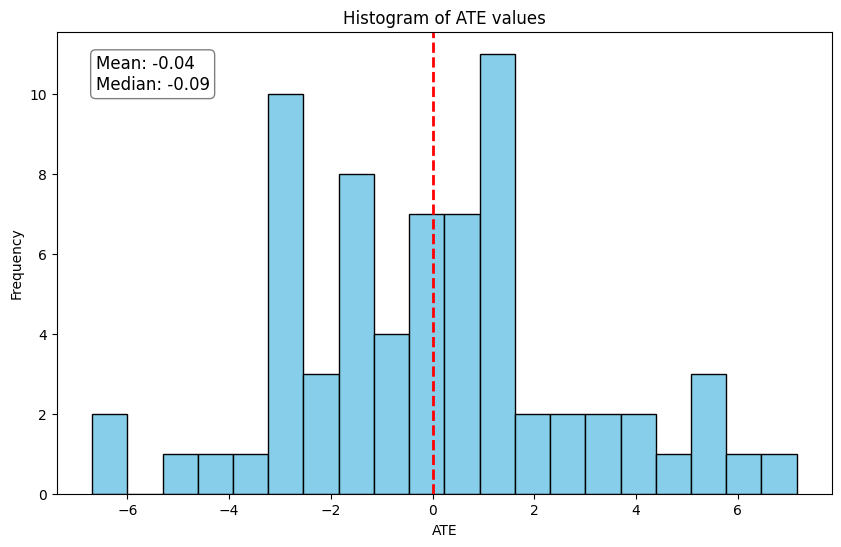

In [202]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming check_df is your dataframe and it has 'experiment_week' and 'ATE' columns
# Example dataframe (remove this part if you already have check_df)
# data = {'experiment_week': [1, 2, 3, 4, 5], 'ATE': [0.1, -0.2, 0.15, -0.1, 0.05]}
# check_df = pd.DataFrame(data)

# Calculate mean and median
mean_ate = check_df['ATE'].mean()
median_ate = check_df['ATE'].median()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(check_df['ATE'], bins=20, color='skyblue', edgecolor='black')

# Add a dashed line at zero
plt.axvline(0, color='red', linestyle='dashed', linewidth=2)

# Add textbox showing mean and median
textstr = f'Mean: {mean_ate:.2f}\nMedian: {median_ate:.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

# Add labels and title
plt.xlabel('ATE')
plt.ylabel('Frequency')
plt.title('Histogram of ATE values')

# Show plot
plt.show()


In [186]:
check = client.query(
"""
SELECT MIN(TXNStartDate) 
FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass 
WHERE Article = "118177"
AND SalesOrg = 1005
AND LOWER(SalesChannelDescription) <> "online"
"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df 

,f0_
0,2021-01-21


In [ ]:
check = client.query(
"""
"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df 

In [83]:
import numpy as np

In [86]:
# Redefine the global_optimization function properly

def global_optimization(corr_matrix):
    # Use the linear_sum_assignment from scipy, which implements the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(-corr_matrix)  # We use -corr_matrix because the algorithm minimizes the cost
    optimized_pairs = [(i, j, corr_matrix[i, j]) for i, j in zip(row_ind, col_ind)]
    
    return pd.DataFrame(optimized_pairs, columns=['test_store', 'control_store', 'coef'])

# Re-run the entire process from generating data to applying the function

# Step 1: Generate simulated sales data for 1000 stores over 12 weeks
np.random.seed(42)
weeks = 12
stores = 1000

# Simulating weekly sales for 1000 stores (normal distribution with some variation)
sales_data = np.random.normal(loc=1000, scale=200, size=(stores, weeks))

# Step 2: Randomly allocate 500 stores to the test group and the remaining to the control group
test_indices = np.random.choice(stores, size=500, replace=False)
control_indices = np.array([i for i in range(stores) if i not in test_indices])

# Step 3: Compute the correlation matrix between test and control stores
test_sales = sales_data[test_indices]
control_sales = sales_data[control_indices]

# Calculate the correlation matrix between each test store and each control store
correlation_matrix = np.corrcoef(test_sales, control_sales)[:500, 500:]

# Step 4: Task 1 - Rolling Join for Closest Correlation
rolling_join_result = rolling_join_closest_correlation(correlation_matrix.copy())

# Step 5: Task 2 - Global Optimization for Aggregate Correlation
global_optimization_result = global_optimization(correlation_matrix.copy())

# Display the results
tools.display_dataframe_to_user(name="Rolling Join Closest Correlation Results", dataframe=rolling_join_result.head())
tools.display_dataframe_to_user(name="Global Optimization Results", dataframe=global_optimization_result.head())

rolling_join_result.head(), global_optimization_result.head()


NameError: name 'linear_sum_assignment' is not defined